In [ ]:
"""
Test script for loading and compute synchronization measures on spike-trains data.
The computed measures are based on ...

To run this code, ensure that te package PySpike is installed. In case it is not run:
...
"""

import numpy as np
import matplotlib.pyplot as plt

from spikingDataUtilities import loadMATData, spikeTimes
import pyspike as psk

In [127]:
# Import data and extract spike times for the different regions and protocols
data = loadMATData("/home/gabricasa/code_repo/BrainHack2026/session1.mat")
print(data.keys())

spikes_hpc = spikeTimes(data['spikes_hpc'], data['protocol_times'])
spikes_nr = spikeTimes(data['spikes_nr'], data['protocol_times'])
spikes_pfc = spikeTimes(data['spikes_pfc'], data['protocol_times'])

dict_keys(['spikes_pfc', 'spikes_hpc', 'spikes_nr', 'ripples', 'spindles', 'nrem', 'rem', 'wake', 'protocol_times', 'protocol_names', 'nr_isr', 'nr_isa'])


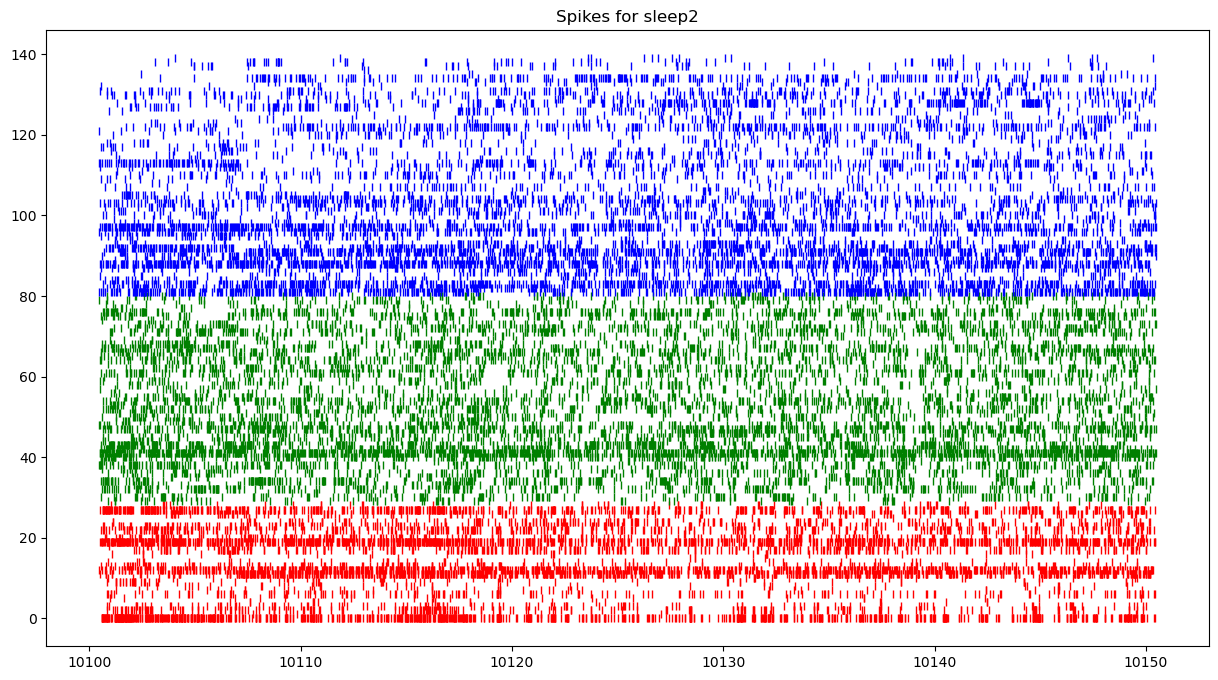

In [128]:
# Visualize raster plots for a specific protocol in a predefined time window (in seconds)
protocol_to_plot = 2  # Select protocol index to plot
t_start = 100
t_end = 150

# Check the length of the spike times and apply a mask to limit to the time window
if (t_end-t_start) > data['protocol_times'][protocol_to_plot][1]-data['protocol_times'][protocol_to_plot][0]:
    raise ValueError("The selected time window exceeds the protocol duration.")

start = data['protocol_times'][protocol_to_plot][0] + t_start
end = data['protocol_times'][protocol_to_plot][0] + t_end

plt.figure(figsize=(15,8))
for i,times in enumerate(spikes_hpc[protocol_to_plot]):
    arr = np.asarray(times)
    mask = (arr >= start) & (arr <= end)
    plt.plot(arr[mask], np.ones(len(arr[mask])) * i, 'r|')

for i,times in enumerate(spikes_nr[protocol_to_plot]):
    arr = np.asarray(times)
    mask = (arr >= start) & (arr <= end)
    plt.plot(arr[mask], np.ones(len(arr[mask])) * (i+len(spikes_hpc[protocol_to_plot])), 'g|')

for i,times in enumerate(spikes_pfc[protocol_to_plot]):
    arr = np.asarray(times)
    mask = (arr >= start) & (arr <= end)
    plt.plot(arr[mask], np.ones(len(arr[mask])) * (i+len(spikes_hpc[protocol_to_plot])+len(spikes_nr[protocol_to_plot])), 'b|')

plt.title(f'Spikes for {data["protocol_names"][protocol_to_plot]}')
plt.show()

# Synchronization measures

In [47]:
def create_pyspike_spike_trains(spike_times, protocol_name, rescale_times=True):
    """
    Input:
        spike_times: List of spikes times for each protocol and neuron.
        protocol_name: Name of the protocol for which to create spike trains.
        rescale_times: boolean indicating whether to rescale spike times to start from 0.
            Done since the synchronisation measures are computed within the same protocols.
    Output: 
        List of PySpike SpikeTrain objects for the given protocol, one per neuron.
        This way we can use PySpike to compute synchronisation measures.
    """
    if protocol_name not in data['protocol_names']:
        raise ValueError(f"Protocol name {protocol_name} not found in data.")
    
    idx = data['protocol_names'].index(protocol_name)
    pyspike_trains_spikes = []
    start, end =  data['protocol_times'][idx]
    
    # If rescale_times is True, rescale spike times to start from 0
    if rescale_times:
        for spikes in spike_times[idx]:
            rescaled_spikes = [(t - start) for t in spikes]
            pyspike_trains_spikes.append(psk.SpikeTrain(rescaled_spikes, edges=(0, end-start)))
    else:
        for spikes in spike_times[idx]:
            pyspike_trains_spikes.append(psk.SpikeTrain(spikes, edges=(start, end)))
    
    return pyspike_trains_spikes

In [88]:
# Chose a specific protocol to inspect the spike trains
protocol_to_investigate = 'sleep2'

s2_pspikes_hpc = create_pyspike_spike_trains(spikes_hpc, protocol_to_investigate)
s2_pspikes_nr = create_pyspike_spike_trains(spikes_nr, protocol_to_investigate)
s2_pspikes_pfc = create_pyspike_spike_trains(spikes_pfc, protocol_to_investigate)

# Print the number of neurons for each region as a check
print(len(s2_pspikes_hpc), len(s2_pspikes_nr), len(s2_pspikes_pfc))

29 52 59


In [93]:
def compute_isi_distance_statistics(spike_trains, protocol_name, tspan='complete', time_profile=False):
    """
    Compute ISI-distance matrix for the selected protocol spike-trains ensemble in a predefined time window (in seconds)
    ...
    """
    idx = data['protocol_names'].index(protocol_name)

    if tspan == 'complete':
        tspan = [0, data['protocol_times'][idx][1]-data['protocol_times'][idx][0]]
    elif (tspan[1]-tspan[0]) > (data['protocol_times'][idx][1]-data['protocol_times'][idx][0]):
        raise ValueError("The selected time window exceeds the protocol duration.")
    
    if not time_profile:
        isi_matrix = psk.isi_distance_matrix(spike_trains, interval=tspan)
        return isi_matrix

    isi_matrix = psk.isi_distance_matrix(spike_trains, interval=tspan)
    isi_profile = psk.isi_profile(spike_trains)
    x_profile, y_profile = isi_profile.get_plottable_data()

    mask = (x_profile >= tspan[0]) & (x_profile <= tspan[1])
    reduced_x_profile = x_profile[mask]
    reduced_y_profile = y_profile[mask]

    return isi_matrix, (reduced_x_profile, reduced_y_profile)


def compute_spike_distance_statistics(spike_trains, protocol_name, tspan='complete', time_profile=False):
    """
    Compute SPIKE-distance matrix for the selected protocol spike-trains ensemble in a predefined time window (in seconds)
    ...
    """
    idx = data['protocol_names'].index(protocol_name)

    if tspan == 'complete':
        tspan = [0, data['protocol_times'][idx][1]-data['protocol_times'][idx][0]]
    elif (tspan[1]-tspan[0]) > (data['protocol_times'][idx][1]-data['protocol_times'][idx][0]):
        raise ValueError("The selected time window exceeds the protocol duration.")

    if not time_profile:
        spike_matrix = psk.spike_distance_matrix(spike_trains, interval=tspan)
        return spike_matrix
    
    spike_matrix = psk.spike_distance_matrix(spike_trains, interval=tspan)
    spike_profile = psk.spike_profile(spike_trains)
    x_profile, y_profile = spike_profile.get_plottable_data()

    mask = (x_profile >= tspan[0]) & (x_profile <= tspan[1])
    reduced_x_profile = x_profile[mask]
    reduced_y_profile = y_profile[mask]

    return spike_matrix, (reduced_x_profile, reduced_y_profile)

def compute_spike_synchronization_statistics(spike_trains, protocol_name, tspan='complete', time_profile=False):
    """
    Compute SPIKE-distance matrix for the selected protocol spike-trains ensemble in a predefined time window (in seconds)
    ...
    """
    idx = data['protocol_names'].index(protocol_name)

    if tspan == 'complete':
        tspan = [0, data['protocol_times'][idx][1]-data['protocol_times'][idx][0]]
    elif (tspan[1]-tspan[0]) > (data['protocol_times'][idx][1]-data['protocol_times'][idx][0]):
        raise ValueError("The selected time window exceeds the protocol duration.")

    if not time_profile:
        spike_sync_matrix = psk.spike_sync_matrix(spike_trains, interval=tspan)
        return spike_sync_matrix
    
    spike_sync_matrix = psk.spike_sync_matrix(spike_trains, interval=tspan)
    spike_sync_profile = psk.spike_sync_profile(spike_trains)
    x_profile, y_profile = spike_sync_profile.get_plottable_data()

    mask = (x_profile >= tspan[0]) & (x_profile <= tspan[1])
    reduced_x_profile = x_profile[mask]
    reduced_y_profile = y_profile[mask]

    return spike_sync_matrix, (reduced_x_profile, reduced_y_profile)

In [94]:
#tspan = [0, 50]  # Time window in seconds
#isi_data = compute_isi_distance_statistics(s2_pspikes_hpc + s2_pspikes_nr + s2_pspikes_pfc, protocol_to_investigate, tspan)
isi_distance_full = compute_isi_distance_statistics(s2_pspikes_hpc + s2_pspikes_nr + s2_pspikes_pfc, protocol_to_investigate)
spike_distance_full = compute_spike_distance_statistics(s2_pspikes_hpc + s2_pspikes_nr + s2_pspikes_pfc, protocol_to_investigate)
spike_sync_full = compute_spike_synchronization_statistics(s2_pspikes_hpc + s2_pspikes_nr + s2_pspikes_pfc, protocol_to_investigate)

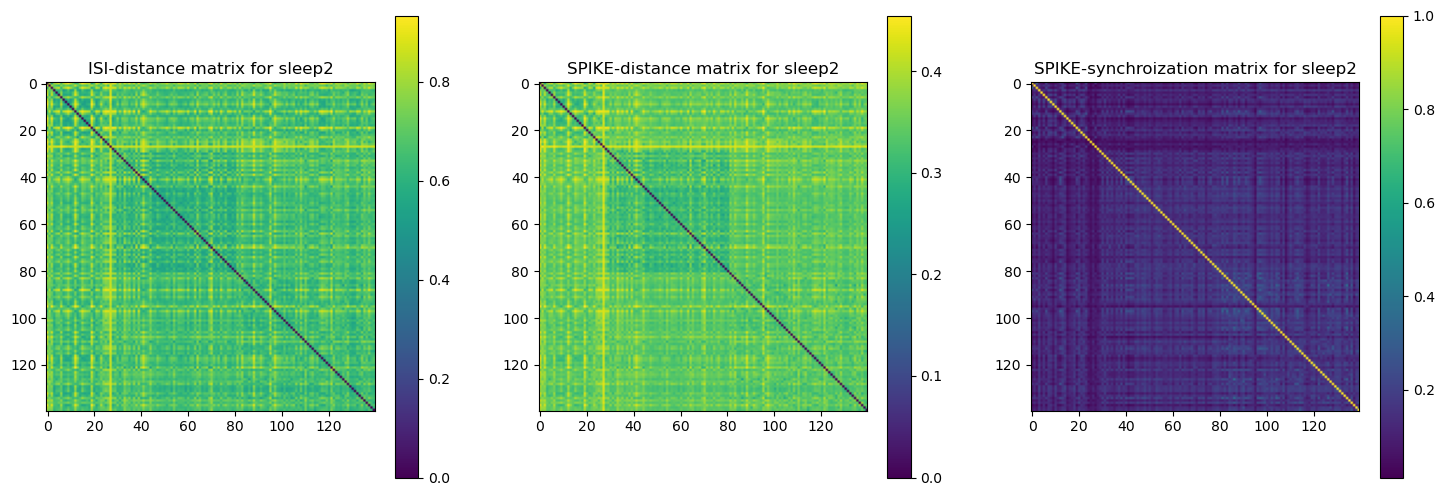

In [97]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title(f'ISI-distance matrix for {protocol_to_investigate}')
plt.imshow(isi_distance_full)
plt.colorbar()

plt.subplot(1,3,2)
plt.title(f'SPIKE-distance matrix for {protocol_to_investigate}')
plt.imshow(spike_distance_full)
plt.colorbar()

plt.subplot(1,3,3)
plt.title(f'SPIKE-synchroization matrix for {protocol_to_investigate}')
plt.imshow(spike_sync_full)
plt.colorbar()

plt.show()

# Firing rates

In [ ]:
def compute_firing_rate(dataset, protocol_times, bin_size=1.0, type='frequency', protocol_based=True):
    """
    Return population firing rate in Hz.
    Input:
        dataset: 
        protocol_times: List of (start, end) times for each protocol
        bin_size: Size of the time bins for histogramming (in seconds)
        protocol_based: Boolean indicating whether to compute firing rates per protocol or for entire recording
    Output:
        population_rates: List of population firing rates for each protocol (if protocol_based=True). Otherwise, returns one listfor entire recording.
    """
    protocol_rates = []
    if dataset.size == 0:
        return protocol_rates

    times = dataset[:,0]
    M = np.size(times)
    bins = np.arange(np.min(times), np.max(times) + bin_size, bin_size)

    if not protocol_based:
        # If not protocol based, return population firing rates for entire recording
        counts, edges = np.histogram(times, bins=bins)
        widths = np.diff(edges)
        population_rate = counts / widths
        return population_rate

    population_rates = []
    for start, end in protocol_times:
        bins = np.arange(start, end + bin_size, bin_size)
        # Select spikes in interval 
        counts, _ = np.histogram(times, bins=bins, range=(start, end))
        widths = np.diff(bins)
        rate = counts / widths

        # Create piecewise constant firing rate by repeating each rate value for its corresponding bin
        population_rates.append(rate)
    
    return population_rates

In [129]:
firing_rate_hpc = compute_firing_rate(data['spikes_hpc'], data['protocol_times'])
firing_rate_nr = compute_firing_rate(data['spikes_nr'], data['protocol_times'])
firing_rate_pfc = compute_firing_rate(data['spikes_pfc'], data['protocol_times'])

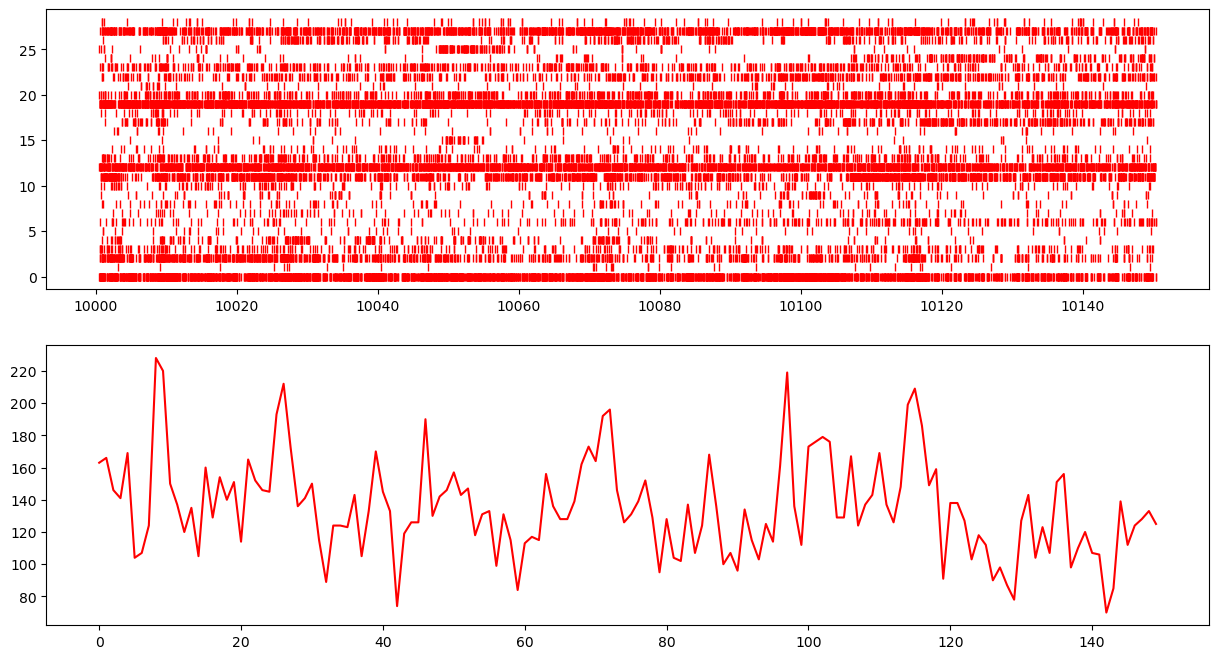

In [131]:
# Visualize raster plots and firing rates for a specific protocol in a predefined time window (in seconds)
protocol_to_plot = 2  # Select protocol index to plot
t_start = 0
t_end = 150

# Check the length of the spike times and apply a mask to limit to the time window
if (t_end-t_start) > data['protocol_times'][protocol_to_plot][1]-data['protocol_times'][protocol_to_plot][0]:
    raise ValueError("The selected time window exceeds the protocol duration.")

start = data['protocol_times'][protocol_to_plot][0] + t_start
end = data['protocol_times'][protocol_to_plot][0] + t_end

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
for i,times in enumerate(spikes_hpc[protocol_to_plot]):
    arr = np.asarray(times)
    mask = (arr >= start) & (arr <= end)
    plt.plot(arr[mask], np.ones(len(arr[mask])) * i, 'r|')

plt.subplot(2,1,2)
plt.plot(firing_rate_hpc[protocol_to_plot][:t_end], label='HPC', color='r')

#for i,times in enumerate(spikes_nr[protocol_to_plot]):
#    arr = np.asarray(times)
#    mask = (arr >= start) & (arr <= end)
#    plt.plot(arr[mask], np.ones(len(arr[mask])) * (i+len(spikes_hpc[protocol_to_plot])), 'g|')
#
#for i,times in enumerate(spikes_pfc[protocol_to_plot]):
#    arr = np.asarray(times)
#    mask = (arr >= start) & (arr <= end)
#    plt.plot(arr[mask], np.ones(len(arr[mask])) * (i+len(spikes_hpc[protocol_to_plot])+len(spikes_nr[protocol_to_plot])), 'b|')
#
#plt.title(f'Spikes for {data["protocol_names"][protocol_to_plot]}')
plt.show()